In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import interp2d

In [21]:
# Load image
scan = plt.imread(r'C:\Users\torre\Downloads\new_fiber_a5.bmp').astype(float)

# Camera settings
pixsize = 5.6  # pixel size in um

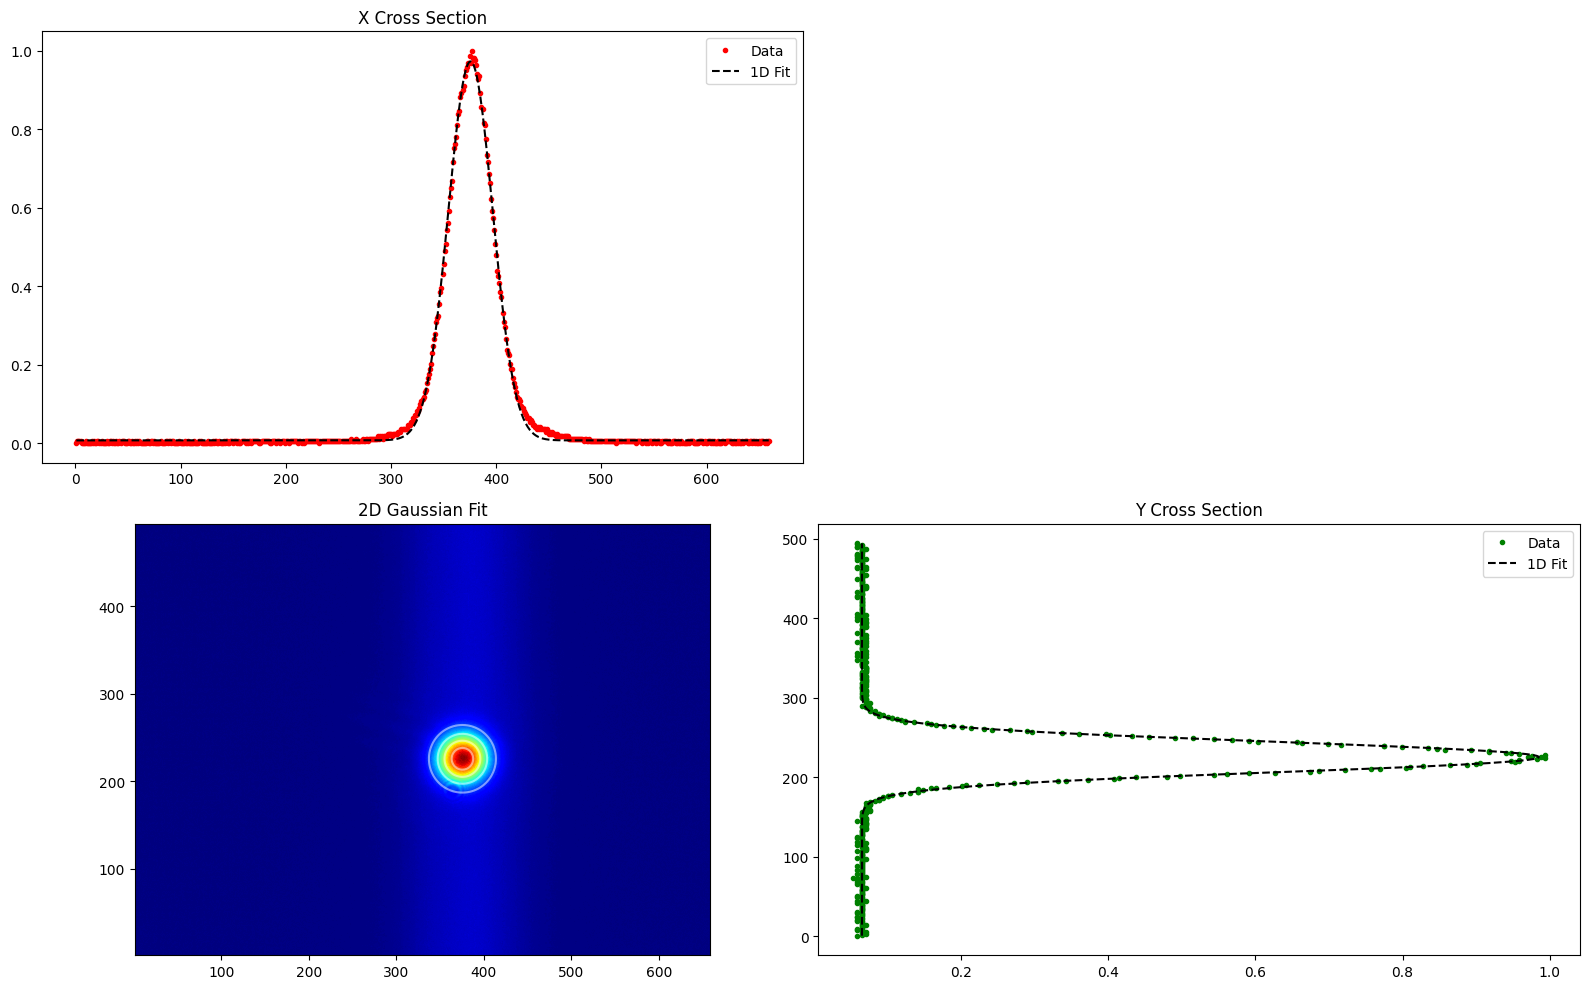

x           y
2D Fit       239.310077  241.463400
1D Fit       235.679229  215.792791
Radius (um)  239.310077  241.463400

In [22]:
# Normalize data to unity
scan /= np.max(scan)

X, Y = scan.shape  # actual image size

# Creating meshgrid
XX, YY = np.meshgrid(np.arange(1, Y + 1), np.arange(1, X + 1))
xdata = np.stack([XX, YY], axis=-1)

# Fitting subroutine
# Parameters: [Amplitude, x0, sigmax, y0, sigmay, offset]
c0 = [1, X / 2, X / 4, Y / 2, Y / 4, 0.1]  # Initial guess parameters

def gauss2d(data, amplitude, x0, sigmax, y0, sigmay, offset):
    return amplitude * np.exp(-((data[:, :, 0] - x0)**2 / (2 * sigmax**2) + (data[:, :, 1] - y0)**2 / (2 * sigmay**2))) + offset

# Fitting subroutine
# Parameters: [Amplitude, x0, sigmax, y0, sigmay, offset]
c0 = [1, X / 2, X / 4, Y / 2, Y / 4, 0.1]  # Initial guess parameters

lb = [0, 0, 0, 0, 0, 0]  # Lower bound
ub = [1, X, X, Y, Y, 1]  # Upper bound

# Flatten the output of gauss2d
def gauss2d_flatten(*args, **kwargs):
    return gauss2d(*args, **kwargs).flatten()

c, _ = curve_fit(gauss2d_flatten, xdata, scan.flatten(), p0=c0, bounds=(lb, ub))

x_max_index = int(np.floor(c[1]))
y_max_index = int(np.floor(c[3]))

# Calculate cross sections
xvh = np.arange(1, Y + 1)
yvh = xvh * 0 + y_max_index
hPoints = np.interp(xvh, XX[0, :], scan[y_max_index, :])

yvv = np.arange(1, X + 1)
xvv = yvv * 0 + y_max_index 
vPoints = np.interp(yvv, YY[:, 0], scan[:, x_max_index])


# Cross section refit
c0h = [1, c[1], c[2], c[5]]  # Inital guess parameters
c0v = [1, c[3], c[4], c[5]]

def gauss(x, amplitude, x0, sigma, offset):
    return amplitude * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

lb = [0, 0, 0, 0]  # Lower bound
ub = [1, Y, Y, 1]  # Upper bound

ch, _ = curve_fit(gauss, xvh, hPoints, p0=c0h, bounds=(lb, ub))
cv, _ = curve_fit(gauss, yvv, vPoints, p0=c0v, bounds=(lb, ub))

data_fitted = gauss2d(xdata, *c)

# Plot profiles
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[1, 0].imshow(scan, extent=[XX.min(), XX.max(), YY.min(), YY.max()], origin='lower', cmap='jet')
axs[1, 0].contour(XX,YY, data_fitted.reshape(scan.shape[0], scan.shape[1]), 5, colors='w',alpha=.5)
axs[1, 0].set_title('2D Gaussian Fit')
axs[0, 0].plot(xvh, hPoints, 'r.', label='Data')
axs[0, 0].plot(xvh, gauss(xvh, *ch), 'k--', label='1D Fit')
axs[0, 0].legend()
axs[0, 0].set_title('X Cross Section')

axs[1, 1].plot(vPoints, yvv,  'g.', label='Data')
axs[1, 1].plot(gauss(yvv, *cv),yvv,'k--', label='1D Fit')
axs[1, 1].legend()
axs[1, 1].set_title('Y Cross Section')
axs[0, 1].set_axis_off()

plt.tight_layout()
plt.show()

display(pd.DataFrame([[2 * c[2] * pixsize,2 * c[4] * pixsize],[2 * ch[2] * pixsize,2 * cv[2] * pixsize],[2 * c[2] * pixsize,2 * c[4] * pixsize]],
                    index = ['2D Fit','1D Fit', 'Radius (um)'],
                    columns = ['x','y']))